<a href="https://colab.research.google.com/github/RizkyArief4/MachineLearning/blob/main/MachineLearning_Week2_Regularized_Linear_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install git+https://github.com/ML-Challenge/learntools.git

  Cloning https://github.com/ML-Challenge/learntools.git to /tmp/pip-req-build-_b6esck6
  Running command git clone -q https://github.com/ML-Challenge/learntools.git /tmp/pip-req-build-_b6esck6
  Created wheel for learntools: filename=learntools-0.3.4-py3-none-any.whl size=207311 sha256=ffe8beb3d3d31dc087cc6104307ceb5bb5d289e327d2874ccea08667144e49a0
  Stored in directory: /tmp/pip-ephem-wheel-cache-gwj6232l/wheels/5e/42/53/aa3198486cfc460e19152f9f799b8d0f549cb88f492acb6033
Successfully built learntools


In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import xgboost as xgb
import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score
from keras.layers import Dense
from keras.models import Sequential
from keras.regularizers import l1
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f67357318d0>,
      dtype=object)

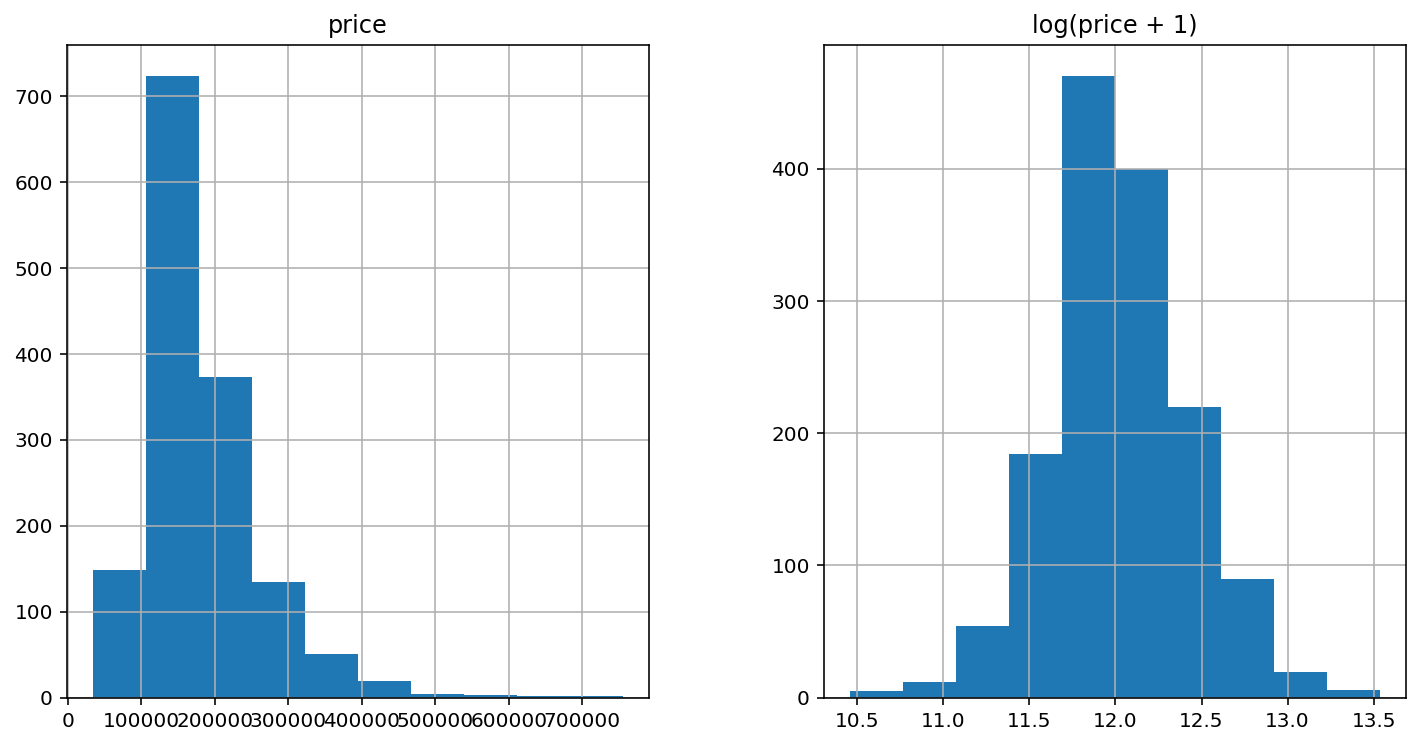

In [8]:
train = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test.csv")
train.head()

all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"price":train["SalePrice"], "log(price + 1)":np.log1p(train["SalePrice"])})
prices.hist()

In [ ]:
train["SalePrice"] = np.log1p(train["SalePrice"])

numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna()))
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])
all_data = pd.get_dummies(all_data)
all_data = all_data.fillna(all_data.mean())

In [13]:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

Text(0, 0.5, 'rmse')

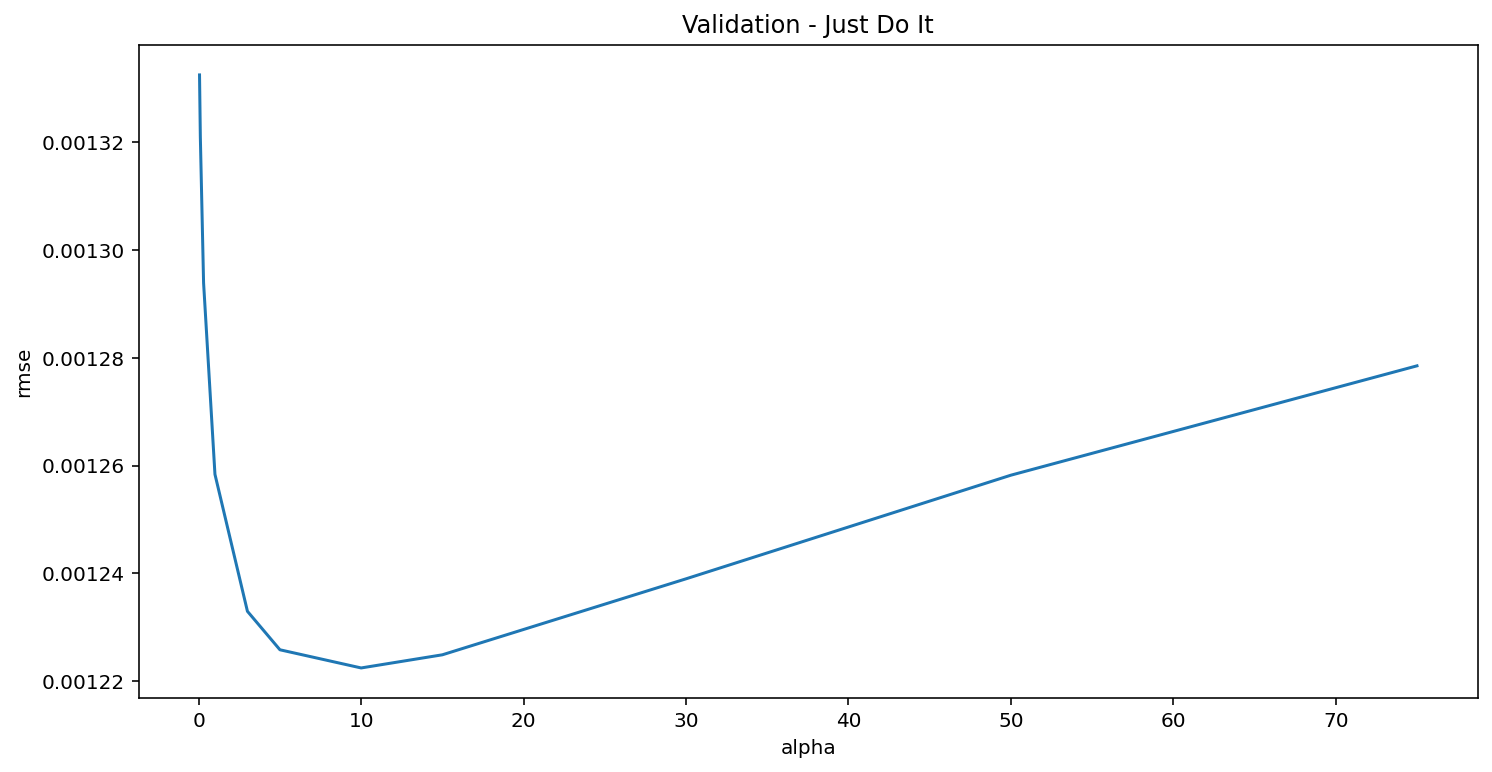

In [14]:
model_ridge = Ridge()
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [15]:
cv_ridge.min()

0.0012224457517532085

In [17]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y)
rmse_cv(model_lasso).mean()

0.0017702895627568324

In [18]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " + 
      str(sum(coef == 0)) + " variables")

Lasso picked 9 variables and eliminated the other 279 variables


Text(0.5, 1.0, 'Coefficients in the Lasso Model')

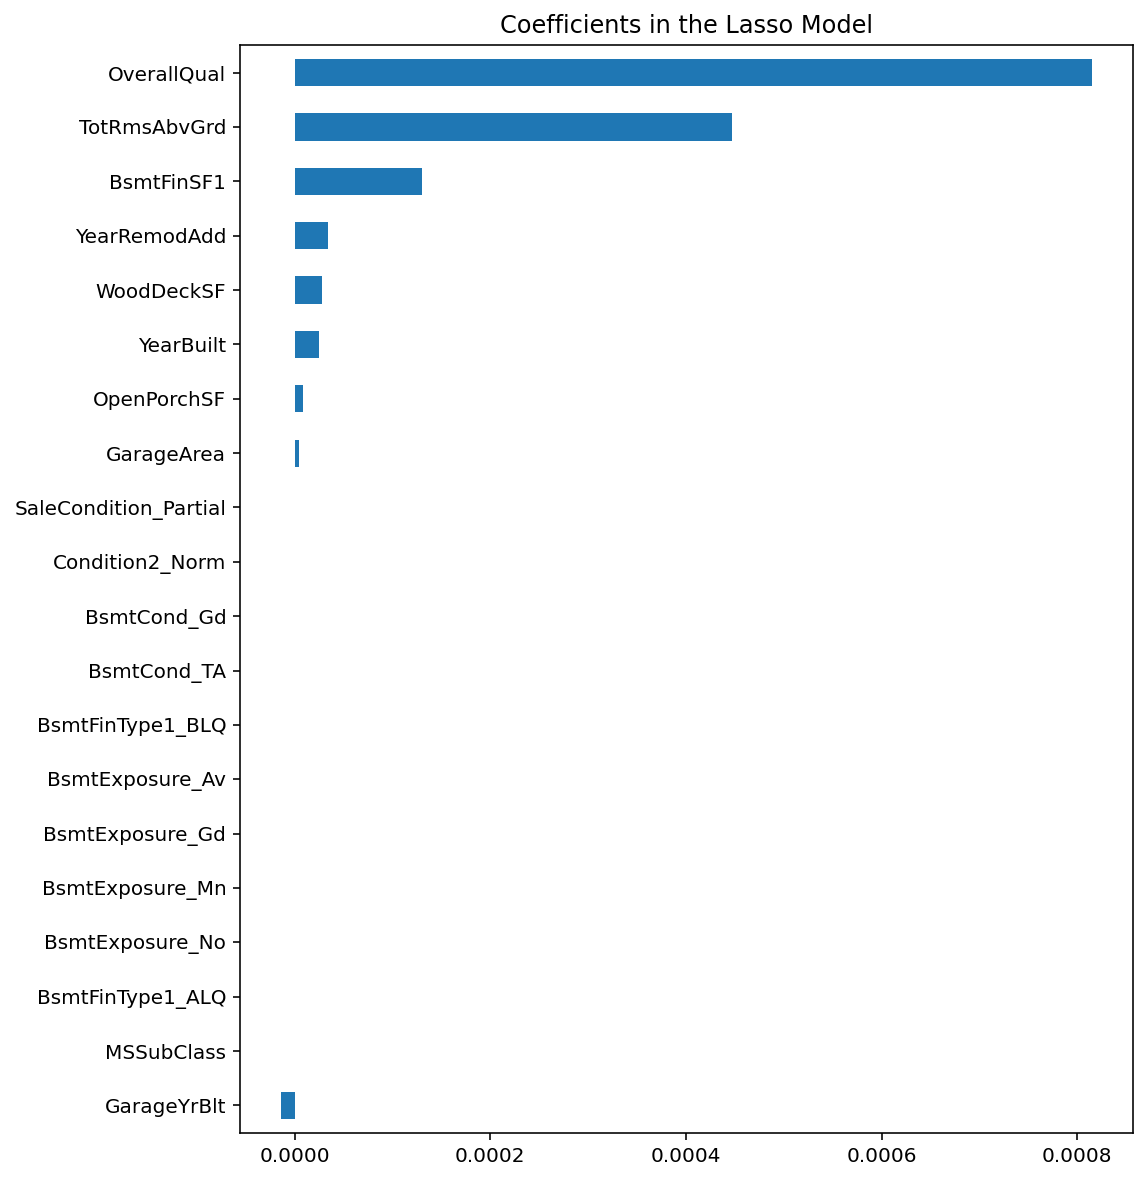

In [19]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

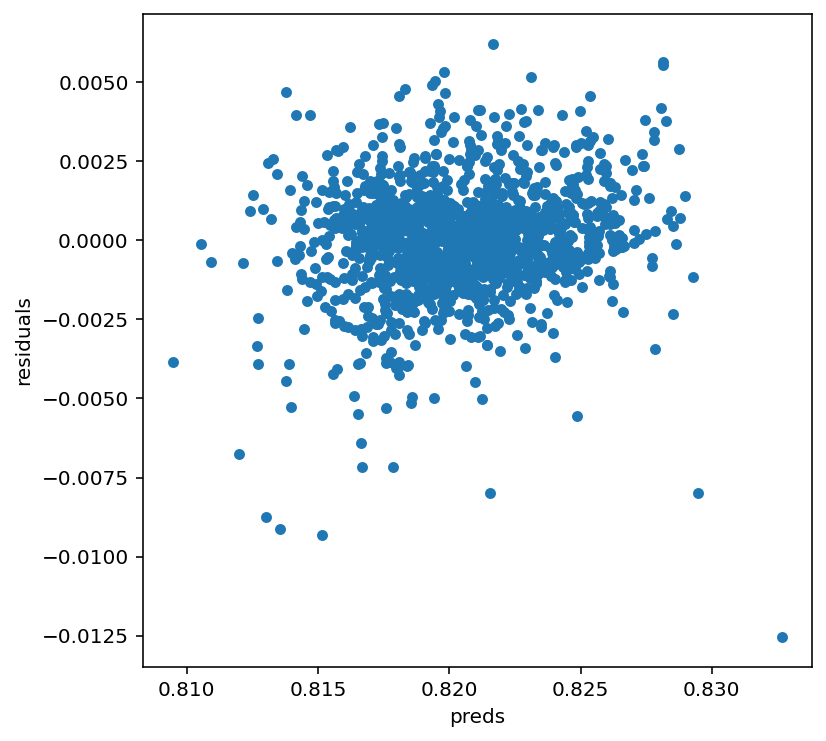

In [20]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":model_lasso.predict(X_train), "true":y})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

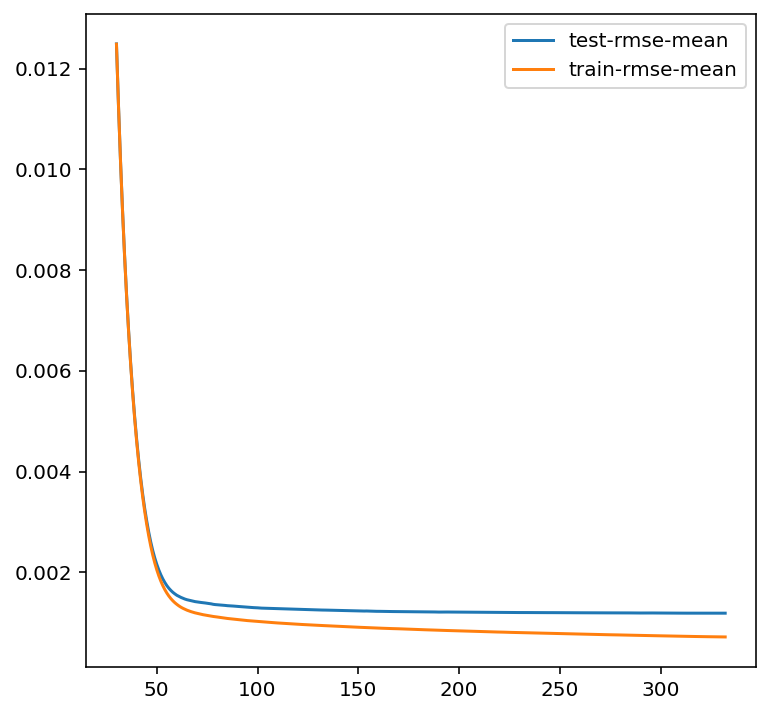

In [21]:
dtrain = xgb.DMatrix(X_train, label = y)
dtest = xgb.DMatrix(X_test)

params = {"max_depth":2, "eta":0.1}
model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)
model.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot()

In [23]:
model_xgb = xgb.XGBRegressor(n_estimators=360, max_depth=2, learning_rate=0.1)
model_xgb.fit(X_train, y)

[21:02:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(max_depth=2, n_estimators=360)

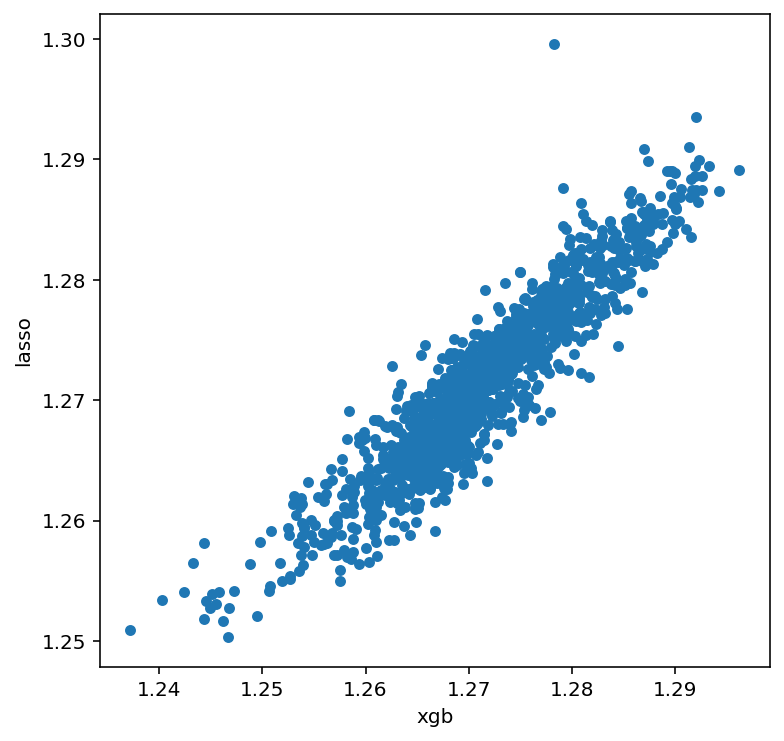

In [24]:
xgb_preds = np.expm1(model_xgb.predict(X_test))
lasso_preds = np.expm1(model_lasso.predict(X_test))

predictions = pd.DataFrame({"xgb":xgb_preds, "lasso":lasso_preds})
predictions.plot(x = "xgb", y = "lasso", kind = "scatter")

In [25]:
preds = 0.7*lasso_preds + 0.3*xgb_preds

solution = pd.DataFrame({"id":test.Id, "SalePrice":preds})
solution.to_csv("ridge_sol.csv", index = False)

X_train = StandardScaler().fit_transform(X_train)
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y, random_state = 3)
X_tr.shape

(1095, 288)

In [26]:
X_tr

array([[ 1.00573733,  0.68066137, -0.46001991, ..., -0.11785113,
         0.4676514 , -0.30599503],
       [-1.12520184,  0.60296111,  0.03113183, ..., -0.11785113,
         0.4676514 , -0.30599503],
       [-1.12520184, -0.02865265, -0.74027492, ..., -0.11785113,
         0.4676514 , -0.30599503],
       ...,
       [ 0.16426234, -0.87075036, -0.81954431, ..., -0.11785113,
        -2.13834494, -0.30599503],
       [ 0.92361154, -0.30038284, -0.44275864, ..., -0.11785113,
         0.4676514 , -0.30599503],
       [ 0.83656519,  1.98505948,  0.46455838, ..., -0.11785113,
         0.4676514 , -0.30599503]])

In [27]:
model = Sequential()
model.add(Dense(256, activation="relu", input_dim = X_train.shape[1]))
#model.add(Dense(1, input_dim = X_train.shape[1], W_regularizer=l1(0.001)))

model.compile(loss = "mse", optimizer = "adam")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               73984     
                                                                 
Total params: 73,984
Trainable params: 73,984
Non-trainable params: 0
_________________________________________________________________


In [28]:
hist = model.fit(X_tr, y_tr, validation_data = (X_val, y_val))

35/35 [==============================] - 1s 12ms/step - loss: 0.5205 - val_loss: 0.4808


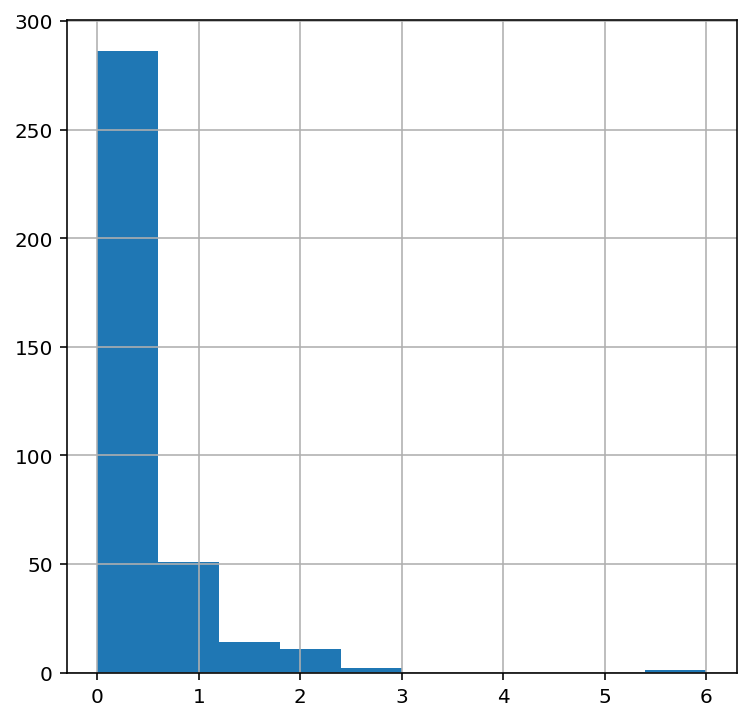

In [29]:
pd.Series(model.predict(X_val)[:,0]).hist()